In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from rw import scan_handler

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

%load_ext autoreload
%autoreload 2

# Reader

In [2]:
file_path = "/home/cmsdaq/Analysis/Data/Test/BAW_6_31.scan"    # series config, read S11 and S21
reader = scan_handler.ScanReader(file_path)        # create the object

In [3]:
# get the name list of all the resonances parameters 
print(reader.get_parameters_tags())

['C_baw', 'L_baw', 'Q', 'Qcorr', 'R_baw', 'R_par', 'asim', 'bw', 'depth', 'er_Q', 'er_asim', 'er_f0', 'er_gamma', 'er_norm', 'f0', 'fcenter', 'fmax', 'fmin', 'gamma', 'input_power', 'norm', 'npt', 'offset_at_peak', 'span', 'sweep', 'x']


In [4]:
d = reader.get_parameters('depth')
tmp = np.where(d!=-2)[0]
print(np.min(d[tmp]))

loc = np.argwhere(d==np.min(d[tmp]))

print(loc)


-0.38216235626640915
[[478]]


No handles with labels found to put in legend.


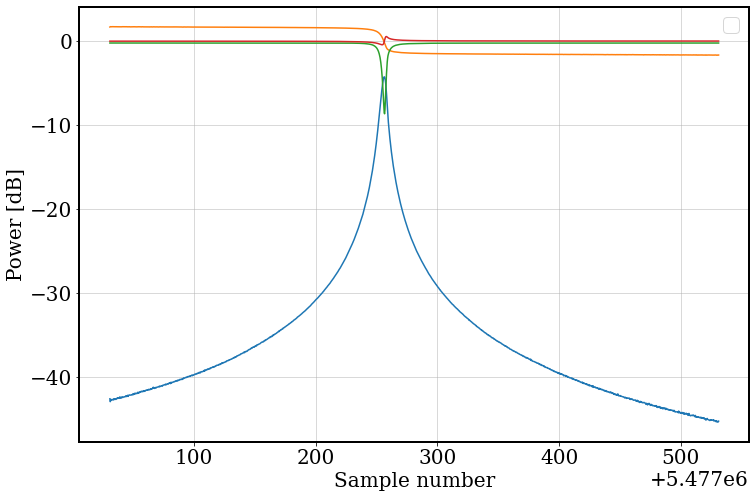

In [5]:
l = 478

power = reader.get_resonance(loc=l,label='S21')['power']
phase = reader.get_resonance(loc=l,label='S21')['phase']
freq = reader.get_resonance(loc=l,label='S21')['freq']

#utils.fit_resonance(freq*1e-6, power,verbose=True)
plt.plot(freq,power)
plt.plot(freq,phase)
power = reader.get_resonance(loc=l,label='S11')['power']
freq = reader.get_resonance(loc=l,label='S11')['freq']
phase = reader.get_resonance(loc=l,label='S11')['phase']
plt.plot(freq,power)
plt.plot(freq,phase)
 
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Power [dB]')
plt.grid(alpha=0.6)
plt.show()

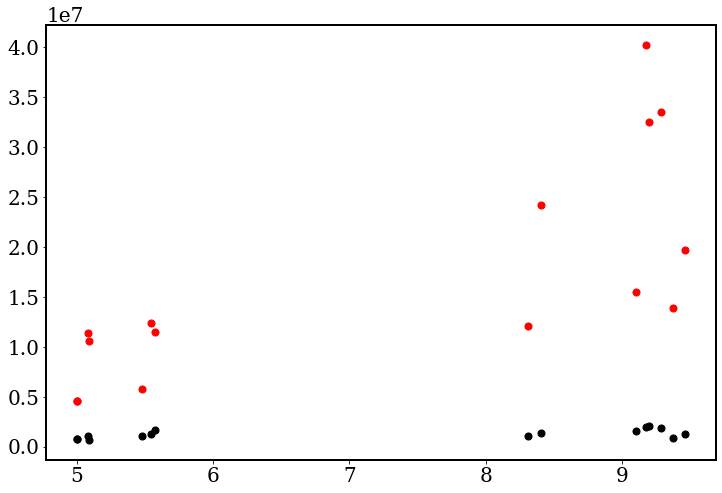

In [7]:
depth = np.fabs(reader.get_parameters("depth"))
corr = reader.get_parameters("Qcorr")
Q    = reader.get_parameters("Q")
f0   = reader.get_parameters("f0")

loc = np.where((depth>0.03) & (depth!=2))[0]

#for res in reader.get_resonances_list():
for l in loc:
    plt.scatter(f0[l], Q[l]*corr[l], s=50, marker = 'o', color='red')
    plt.scatter(f0[l], Q[l], s=50, marker = 'o', color='black')

plt.show()



In [8]:
for l in loc:
    plt.scatter(f0[l], corr[l], s=50, marker = 'o', color='red')

plt.show()

In [10]:
#test fit
from process import utils

reso = reader.get_resonance(loc=478, label='S21')
freq = reso["freq"]
pow = reso["power"]

#plt.plot(freq, pow)
#plt.show()

utils.fit_resonance(freq*1e-6, pow, verbose=True)



conversion is: dBm-W
Parametro  1 :  -3.0083602784296405e-06  +/-  3.3048354665663727e-09
Parametro  2 :  2.5653004489926864e-06  +/-  3.40784265972663e-09
Parametro  3 :  5.477256441545782  +/-  4.439270537429008e-09
Parametro  4 :  -0.7362459547534712  +/-  0.15433225816730042
Parametro  5 :  4.032586120970553  +/-  0.845321429895066
Parametro  6 :  1.3596111408106357  +/-  0.004816498559294146
Q = 1.07e+06  +/-  0.0008652535298881771


In [11]:
from matplotlib  import cm
depth = np.fabs(reader.get_parameters('depth'))
Q = reader.get_parameters('Q')
corr = reader.get_parameters('Qcorr')
newQ = Q*corr
peak_pos = reader.get_parameters('f0')


depth_thr = 0.01 #è l'altezza dei picchi sotto la quale non plotta il Q valore
ii = np.where(depth>depth_thr)[0]
ii2 = np.where(depth<=depth_thr)[0]
ii3 = np.where((Q != -2) & (Q<1e9))[0]

ii = np.intersect1d(ii,ii3)
ii2 = np.intersect1d(ii2,ii3)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(25)

d = ax1.scatter(peak_pos[ii2],-depth[ii2],s=50,          marker = 'o', color='grey')
d = ax1.scatter(peak_pos[ii], -depth[ii], s=50, c=newQ[ii], marker = 'o', cmap = cm.cool )
ax1.set_title(r'BAW$_{TOBAR}$, T=300K')
fig.colorbar(d,label='Q',format='%.1e', ax=ax1)
ax1.set_xlabel(r'$f_{res}$ [MHz]')
ax1.set_ylabel('Resonance depth [dB]')

e = ax2.scatter(peak_pos[ii], newQ[ii],s=50, c=-depth[ii], marker = 'o', cmap = cm.cool )
ax2.set_title(r'BAW$_{TOBAR}$, T=300K')
fig.colorbar(e,label='depth [dB]',format='%.1e', ax=ax2)
ax2.set_xlabel(r'$f_{res}$ [MHz]')
ax2.set_ylabel('Resonance Q')

ax1.grid(alpha=0.6)
ax2.grid(alpha=0.6)

In [ ]:
'''
comment: the above plot has a scale which is obtained by:
- acquiring i, q in polar mode with the VNA
- from i,q the logMag is obtained as 20*log10(sqrt(i**2 + q**2))
- at this point we have a ratio in dB in hands. a linear ratio is then obtained with the following conversion: 10**(Y/10)
- the minus (-) sign is added artificially just to help the comparison with old plots

observation:
- the above plot has a Y scale which seems linear compared with the same plot from the 3 ports VNA which seems logaritmic instead --> to be understood

to make the plot obtained with the 2 ports and the 3 ports VNAs, one should do:
- take the Y value on the plot from the 3 ports VNA, consider the original power injected (-30 dBm) and ontain the depth of the resonance in mW to be compared with the plot from the 3 ports VNA: 10^(-30/10)*0.4

'''